# Sliding window optimization
This notebook covers the optimization of the Sliding window function

## library imports

In [ ]:
import pandas as pd
from numpy import array
from functions.Sliding_Functions import local_rmsd_plotter
from functions.CIF_Functions import make_df_atomlist
import matplotlib.pyplot as plt


## Reading in dataframes

In [26]:
atomlist = ["CA","N","C"]

## PTMS
ptm_df = make_df_atomlist("cif_files/Predictions/SEEDMATCHED/fold_adnan_seed42_ptms/fold_adnan_seed42_ptms_model_3.cif",atomlist)
## NO PTMS
noptm_df = make_df_atomlist("cif_files/Predictions/SEEDMATCHED/fold_adnan_seed1_noptms/fold_adnan_seed1_noptms_model_1.cif",atomlist)
## CRYSTAL
crystal_df = make_df_atomlist("cif_files/Crystals/7stz (1).cif",atomlist)

## Showing PTM/noPTM
We are trying to get a nice seperation at certain local events between these 2 groups of proteins, with reference to the ground truth. To see local changes we inspect the affect of our window size first

Text(0, 0.5, 'RMSD')

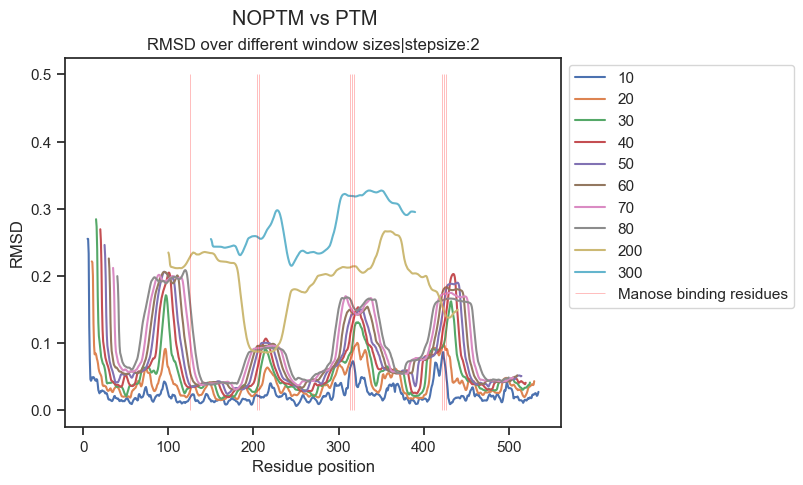

In [27]:
for win in [10,20,30,40,50,60,70,80,200,300]:  
    x,y,pLDDTs = local_rmsd_plotter(ptm_df,noptm_df,stepsize=2,win_size=win*len(atomlist))
    plt.plot(array(x)/len(atomlist),array(y)/len(atomlist),label=win)

plt.vlines(array([126, 204,206, 314, 316, 318,422,424,426]),0,.5,colors="red",alpha=.3,label="Manose binding residues",linewidth=.6)
plt.legend(bbox_to_anchor=(1,1))
plt.suptitle("NOPTM vs PTM")
plt.title("RMSD over different window sizes|stepsize:2")
plt.xlabel("Residue position")
plt.ylabel("RMSD")

## Manose region vs Hinge region
Using the plot above is a little misleading, I plot the vertical lines of where I want things to be different between these groups.This way of visualizing is prone to confirmation bias.
I will show below that the bigger window sizes actually line up much better with the hinge regions in the protein

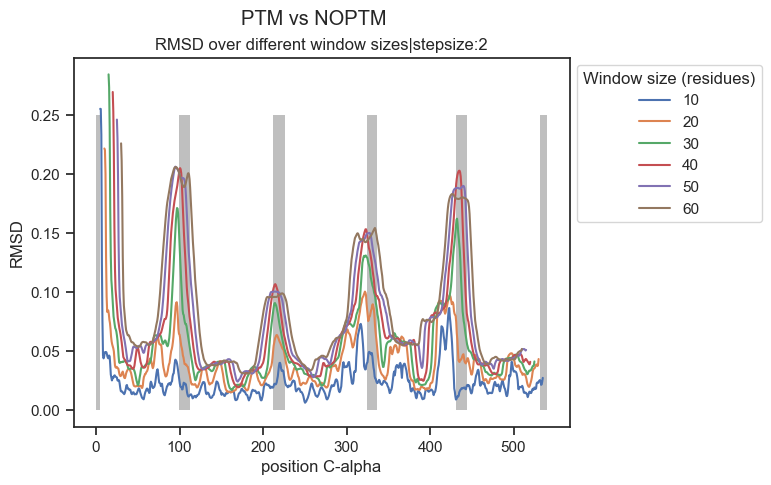

In [28]:
from matplotlib.patches import Rectangle
for win in [10,20,30,40,50,60]:  
    x,y,pLDDTs = local_rmsd_plotter(ptm_df,noptm_df,stepsize=2,win_size=win*len(atomlist))
    plt.plot(array(x)/len(atomlist),array(y)/len(atomlist),label=win)

#plt.vlines(array([5,99,113,212,226,324,337,431,444,532]),0,.3,colors="grey",alpha=.5,label="Interbarrel regions",linewidth=.6)
for i,j in [(0,5),(99,14),(212,14),(324,13),(431,13),(532,8)]:
    plt.gca().add_patch(Rectangle((i,0),j,.25,linewidth=1,edgecolor='none',facecolor='grey',alpha=.5))


#plt.vlines(array([126, 204,206, 314, 316, 318,422,424,426]),0,.25,alpha=.5,colors="red",label="Manose binding residues",linewidth=.6)
plt.suptitle("PTM vs NOPTM")
plt.title("RMSD over different window sizes|stepsize:2")
plt.legend(bbox_to_anchor=(1,1),title="Window size (residues)")
plt.xlabel("position C-alpha")
plt.ylabel("RMSD")
plt.show()

Using this information it almost looks as if the larger window sizes are pulling up the RMSD because they are overlapping with the hinge regions. To find a difference between whether the localRMSD correlates with the hinges or with the manose regions I create an idealised control. Shown below

## Optimizing window size
The code below runs through many different window sizes and computes similarity between the 2 predictions as compared to the ground truth crystal (takes a while to run ~2 minutes)

In [29]:
import math
from scipy.stats import mannwhitneyu
from scipy.signal import find_peaks 
import seaborn as sns
import numpy as np

window_list = [x for x in range(10,400,5)]

mannwhitnylist = []
for win in window_list:  
    x,y,pLDDTs = local_rmsd_plotter(ptm_df,crystal_df,stepsize=1,win_size=win)
    x2,y2,pLDDTs2 = local_rmsd_plotter(noptm_df,crystal_df,stepsize=1,win_size=win)
    mannwhitnylist.append(math.log10(mannwhitneyu(y,y2).pvalue)*-1)

We can take the gradient of this list and plot lines where the rate of change is highest, this way we trade-of local accuracy for the largest jump in p-value between these lists

Maximum slope at xvalues [ 25  45  55  68  80  95 105 123]


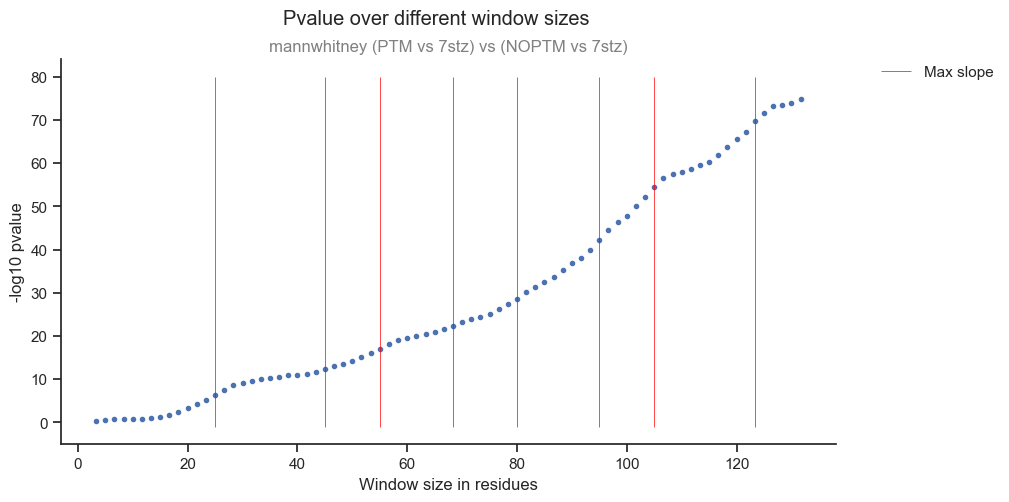

In [30]:

plt.figure(figsize=(10,5))
plt.scatter(array(window_list)/3,mannwhitnylist,marker=".")
plt.suptitle("Pvalue over different window sizes")
plt.title("mannwhitney (PTM vs 7stz) vs (NOPTM vs 7stz)",color="grey")
plt.xlabel("Window size in residues")
plt.ylabel("-log10 pvalue")

peaks = array((find_peaks(np.gradient(mannwhitnylist),height=.5,distance=5)[0]*5)+10)/3
plt.vlines(peaks,ymin=-1,ymax=80,color="red",linewidth=.5,label="Max slope")
print("Maximum slope at xvalues",peaks.astype(int))
sns.despine(offset = 0)
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.,prop={'size': 11},frameon=False)


## Maximum Gradient plotted

[ 25.          45.          55.          68.33333333  80.
  95.         105.         123.33333333]


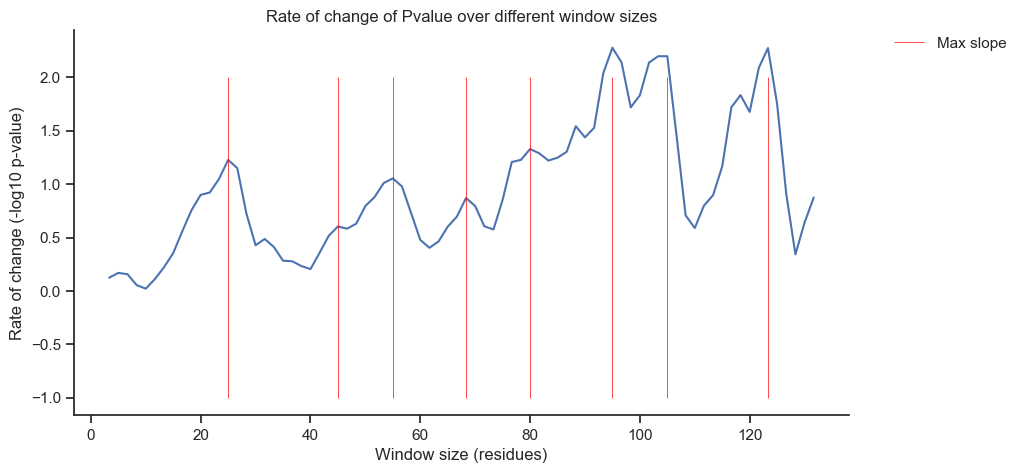

In [31]:
plt.figure(figsize=(10,5))
plt.plot(array(window_list)/len(atomlist),np.gradient(mannwhitnylist))
plt.vlines(((find_peaks(np.gradient(mannwhitnylist),height=.5,distance=5)[0]*5)+10)/len(atomlist),ymin=-1,ymax=2,color="red",linewidth=.5,label="Max slope")
plt.xlabel("Window size (residues)")
plt.ylabel("Rate of change (-log10 p-value)")
sns.despine(offset=0)
print(((find_peaks(np.gradient(mannwhitnylist),height=.5,distance=5)[0]*5)+10)/len(atomlist))
plt.title("Rate of change of Pvalue over different window sizes")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.,prop={'size': 11},frameon=False)

## Step size optimization
Although straightforward, step size denotes the amount of detail in the 2 lists, we want to have the maximum amount of detail

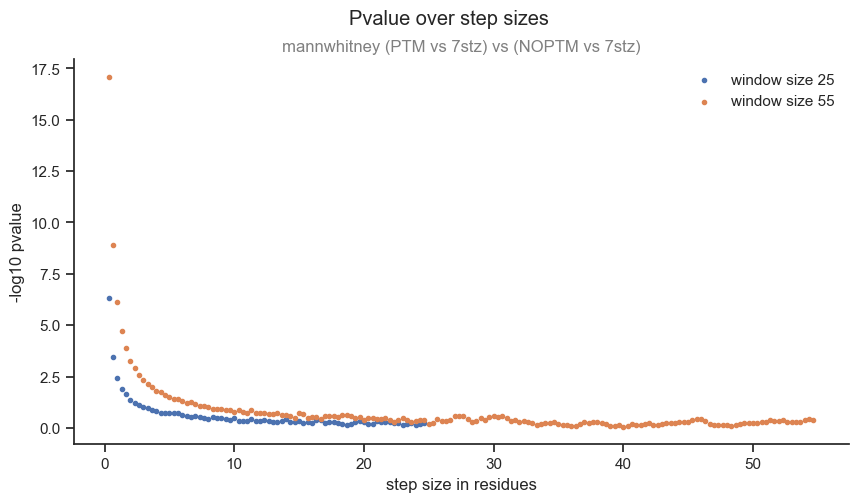

In [32]:
win = 25*len(atomlist) # Using the newly found window size 25 residues
step_list = list(range(1,win,1))
plt.figure(figsize=(10,5))
mannwhitnylist = []
for step in step_list:  
    x,y,pLDDTs = local_rmsd_plotter(ptm_df,crystal_df,stepsize=step,win_size=win)
    x2,y2,pLDDTs2 = local_rmsd_plotter(noptm_df,crystal_df,stepsize=step,win_size=win)
    mannwhitnylist.append(math.log10(mannwhitneyu(y,y2).pvalue)*-1)
plt.scatter(array(step_list)/len(atomlist),mannwhitnylist,marker=".",label=f"window size {25}")

win =55*len(atomlist)
step_list = list(range(1,win,1))

mannwhitnylist = []
for step in step_list:  
    x,y,pLDDTs = local_rmsd_plotter(ptm_df,crystal_df,stepsize=step,win_size=win)
    x2,y2,pLDDTs2 = local_rmsd_plotter(noptm_df,crystal_df,stepsize=step,win_size=win)
    mannwhitnylist.append(math.log10(mannwhitneyu(y,y2).pvalue)*-1)
plt.scatter(array(step_list)/len(atomlist),mannwhitnylist,marker=".",label=f"window size {55}")

plt.suptitle("Pvalue over step sizes")
plt.title("mannwhitney (PTM vs 7stz) vs (NOPTM vs 7stz)",color="grey")
plt.xlabel("step size in residues")
plt.ylabel("-log10 pvalue")
plt.legend(frameon=False)
sns.despine(offset=0)

## Using the new optimized function to inspect the rmsds

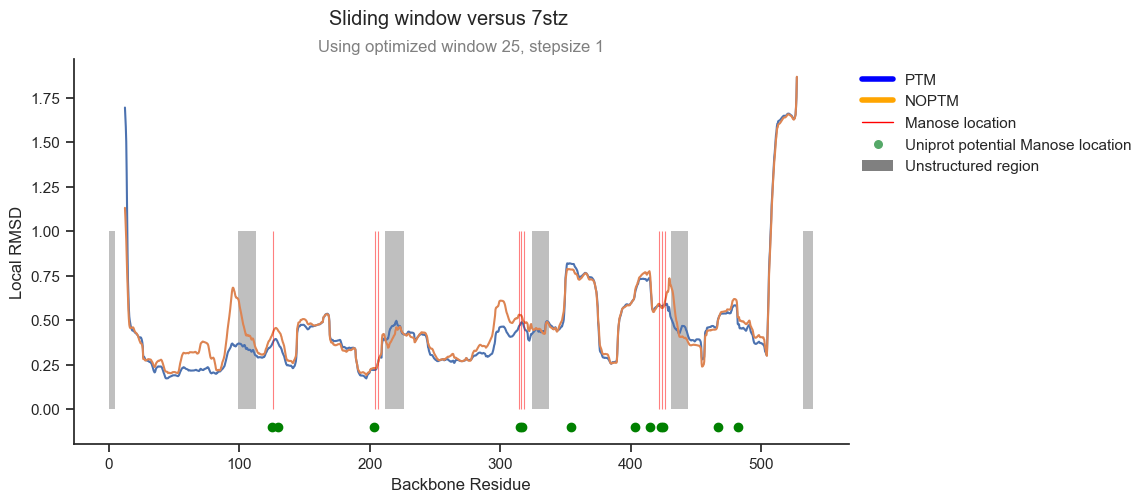

In [33]:
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

sns.set(style='ticks')
step = 1
plt.figure(figsize=(10,5))
win = 25*len(atomlist)
x1,y1,pLDDTs1 = local_rmsd_plotter(ptm_df,crystal_df,stepsize=step,win_size=win)
plt.plot(array(x1)/len(atomlist),y1,label="PTM")

x2,y2,pLDDTs2 = local_rmsd_plotter(noptm_df,crystal_df,stepsize=step,win_size=win)
plt.plot(array(x2)/len(atomlist),y2,label="NOPTM")

for i,j in [(0,5),(99,14),(212,14),(324,13),(431,13),(532,8)]:
    plt.gca().add_patch(Rectangle((i,0),j,1,linewidth=1,edgecolor='none',facecolor='grey',alpha=.5))

manoselocations = array([280,285,358,470,472,509,558,570,578,580,622,637]) - 155

plt.vlines(array([126, 204,206, 314, 316, 318,422,424,426]),0,1,alpha=.5,colors="red",label="Manose binding residues",linewidth=.8)
plt.scatter(x=manoselocations,y=[-.1 for i in manoselocations],color="green")
plt.xlabel("Backbone Residue")
plt.ylabel("Local RMSD")
plt.suptitle("Sliding window versus 7stz")
plt.title("Using optimized window 25, stepsize 1",c="grey")

legend_elements = [Line2D([0], [0], color='blue', lw=4, label='PTM'),
                   Line2D([0], [0], color='orange', lw=4, label='NOPTM'),
                   Line2D([0], [0], color='red', lw=1, label='Manose location'),
                   Line2D([0], [0], marker='.', color='w', label='Uniprot potential Manose location',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Unstructured region')]
plt.legend(handles=legend_elements,frameon=False,bbox_to_anchor=(1,1),prop={'size': 11})
sns.despine(offset=0)
#plt.grid()
plt.show()


## Colouring the difference, by desity of delta

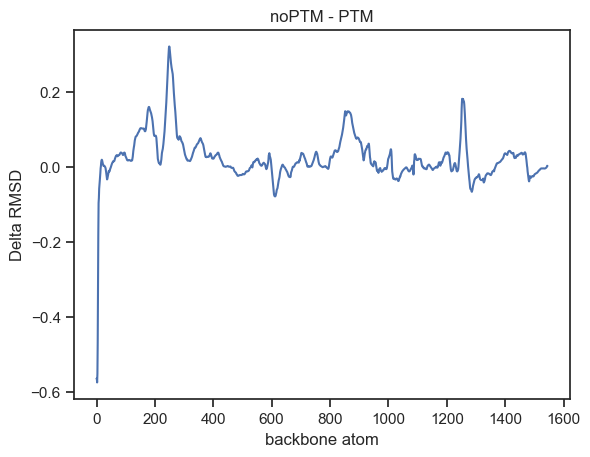

In [34]:
from scipy.stats import normaltest,skew
from scipy.stats import mannwhitneyu
# Test if data is normally distributed
data = array(y2)-array(y1)

plt.plot(data)
plt.xlabel("backbone atom")
plt.ylabel("Delta RMSD")
plt.title("noPTM - PTM")
plt.show()

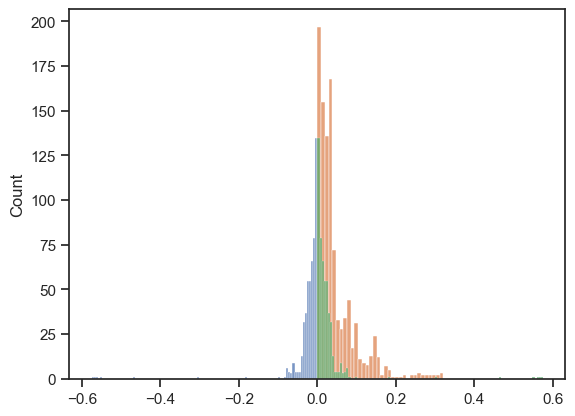

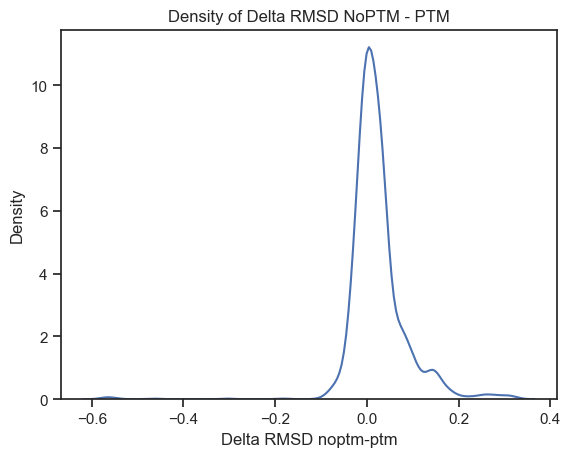

In [35]:
x = [i for i in data if i <0]
sns.histplot(x)
x = [i for i in data if i >0]
sns.histplot(x)
x = [-1*i for i in data if i <0]
sns.histplot(x)
plt.show()
kdeplot = sns.kdeplot(data)
plt.xlabel( "Delta RMSD noptm-ptm")
plt.title("Density of Delta RMSD NoPTM - PTM")
plt.show()

2sigma 0.12207154959086866


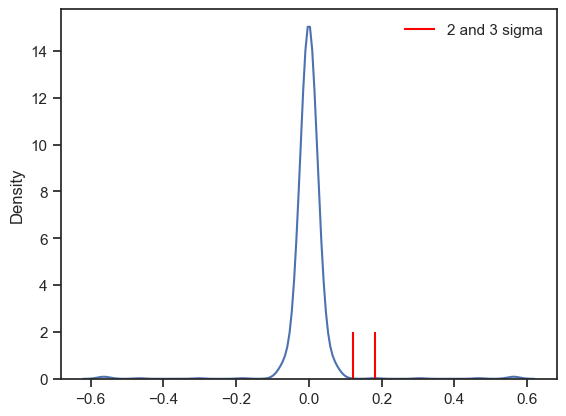

2sigma 0.05818302185076652


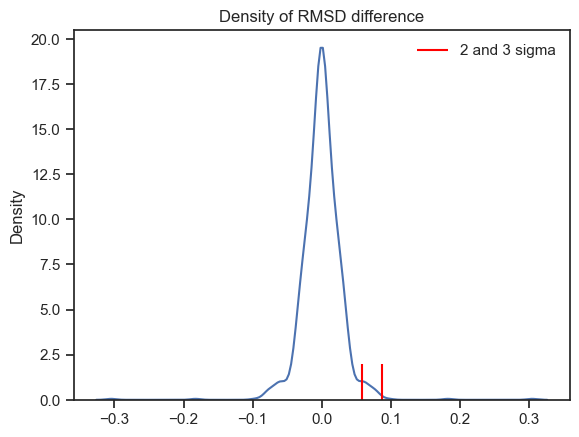

In [36]:
data = array(y2)-array(y1)
#data_truncated = [i for i in data if i>-.5 and i<.5]
sym_neg_data = [i for i in data if i<0] + [-1*i for i in data if i<0]
sns.kdeplot(sym_neg_data)
st_dev = np.std(sym_neg_data)
print("2sigma",st_dev+st_dev)
plt.vlines([st_dev+st_dev,st_dev+st_dev+st_dev],0,2,color="red",label="2 and 3 sigma")
plt.legend(frameon=False)
plt.show()

# Removal of outliers

data_t = [i for i in data if i<.4 and i> -.4]
#data_truncated = [i for i in data if i>-.5 and i<.5]
sym_neg_data = [i for i in data_t if i<0] + [-1*i for i in data_t if i<0]
sns.kdeplot(sym_neg_data)
st_dev = np.std(sym_neg_data)
print("2sigma",st_dev*2)
plt.title("Density of RMSD difference")
plt.vlines([st_dev+st_dev,st_dev+st_dev+st_dev],0,2,color="red",label="2 and 3 sigma")
plt.legend(frameon=False)
plt.show()

The first couple residues really skew and narrow our plot and are only this high for the first "dangling" residues of the protein, these values are considered outliers and are truncated

## Plotting with these sigma values

Text(0.5, 0, 'Backbone Atom position')

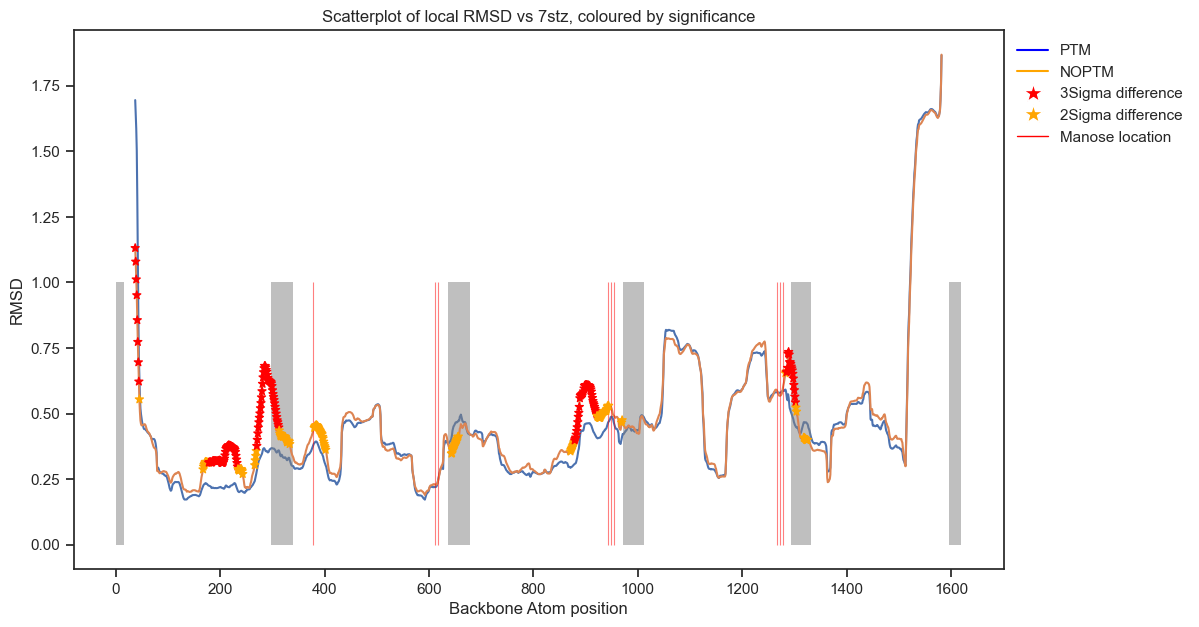

In [ ]:
sig3 = 3*np.std(sym_neg_data)
sig2 = 2*np.std(sym_neg_data)

colorlist = ["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "blue" for i in data]
plt.figure(figsize=(12,7))
plt.plot(x1,y1,zorder=1)
plt.plot(x2,y2,zorder=2)
plt.scatter(x1,y1,color=["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "b" for i in data],marker="*",alpha=[0 if i> sig3 or i< -sig3 else 0 if i> sig2 or i< -sig2 else 0 for i in data],zorder=3)
plt.scatter(x1,y2,color=["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "g" for i in data],marker="*",alpha=[1 if i> sig3 or i< -sig3 else 1 if i> sig2 or i< -sig2 else 0 for i in data],zorder=4)

plt.vlines(array([126, 204,206, 314, 316, 318,422,424,426])*len(atomlist),0,1,alpha=.5,colors="red",label="Manose binding residues",linewidth=.8)

for i,j in [(0,5),(99,14),(212,14),(324,13),(431,13),(532,8)]:
    plt.gca().add_patch(Rectangle((i*len(atomlist),0),j*len(atomlist),1,linewidth=1,edgecolor='none',facecolor='grey',alpha=.5))


legend_elements = [Line2D([0], [0], color='blue', label='PTM', markersize=15),
                   Line2D([0], [0], color='orange', label='NOPTM', markersize=15),
                   Line2D([0], [0], marker='*', color='w', label='3Sigma difference',markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='*', color='w', label='2Sigma difference',markerfacecolor='orange', markersize=15),
                   Line2D([0], [0], color='red', lw=1, label='Manose location')]
plt.legend(handles=legend_elements,frameon=False,bbox_to_anchor=(1,1),prop={'size': 11})

plt.title("Scatterplot of local RMSD vs 7stz, coloured by significance")
plt.ylabel("RMSD")
plt.xlabel("Backbone Atom position")

## Visualization

Text(0.5, 125.24999999999999, '7stz B_Factor')

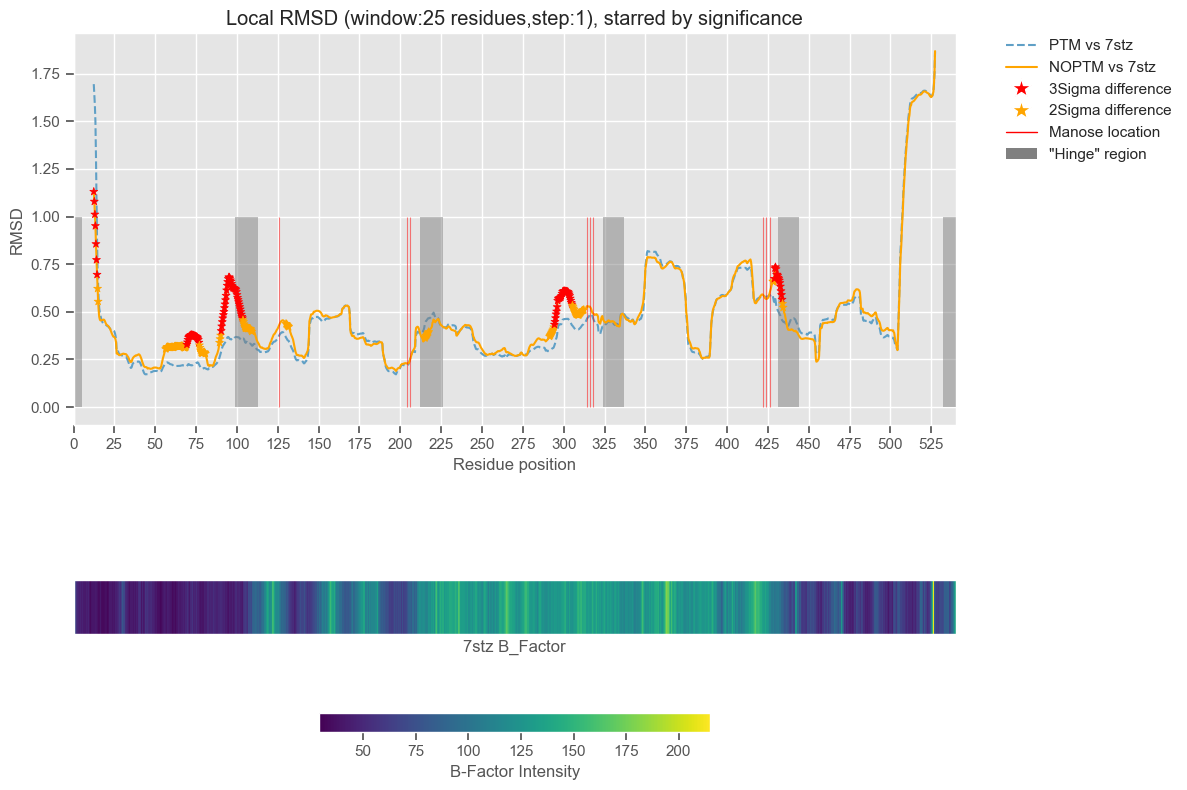

In [39]:
# Define which atoms to use
atomlist = ["CA","N","C"]
#atomlist = ["CA"]

# Read CIF and turn into df
## PTMS
ptm_df = make_df_atomlist("cif_files/Predictions/SEEDMATCHED/fold_adnan_seed42_ptms/fold_adnan_seed42_ptms_model_3.cif",atomlist)
## NO PTMS
noptm_df = make_df_atomlist("cif_files/Predictions/SEEDMATCHED/fold_adnan_seed1_noptms/fold_adnan_seed1_noptms_model_1.cif",atomlist)

## CRYSTAL
crystal_df = make_df_atomlist("cif_files/Crystals/7stz (1).cif",atomlist)

# Compare to the crystal
win = 25*len(atomlist)
x1,y1,pLDDTs1 = local_rmsd_plotter(ptm_df,crystal_df,stepsize=1,win_size=win)
x2,y2,pLDDTs2 = local_rmsd_plotter(noptm_df,crystal_df,stepsize=1,win_size=win)

# Plot the difference
data = array(y2)-array(y1)

# Remove outliers formed by the 5 initial values at the beginning of prediction
data_truncated = [i for i in data if i>-.5 and i<.5]
sym_neg_data = [i for i in data_truncated if i<0] + [-1*i for i in data_truncated if i<0]

# Plot this symetrical density plot
#sns.kdeplot(sym_neg_data)
st_dev = np.std(sym_neg_data)
#print("2sigma",2*st_dev)
#plt.vlines([2*st_dev,3*+st_dev],0,2,color="red",label="2 and 3 sigma")
#plt.legend(frameon=False)
#plt.show()

sig3 = 3*np.std(sym_neg_data)
sig2 = 2*np.std(sym_neg_data)

plt.style.use('ggplot')

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=False,figsize=(12,8))


#colorlist = ["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "blue" for i in data]


ax.plot(array(x1)/len(atomlist),y1,zorder=1,color='#60a0c6',linestyle="dashed")
ax.plot(array(x2)/len(atomlist),y2,zorder=2,color='orange')
ax.scatter(array(x1)/len(atomlist),y1,color=["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "b" for i in data],marker="*",alpha=[0 if i> sig3 or i< -sig3 else 0 if i> sig2 or i< -sig2 else 0 for i in data],zorder=3)
ax.scatter(array(x1)/len(atomlist),y2,color=["red" if i> sig3 or i< -sig3 else "orange" if i> sig2 or i< -sig2 else "g" for i in data],marker="*",alpha=[1 if i> sig3 or i< -sig3 else 1 if i> sig2 or i< -sig2 else 0 for i in data],zorder=4)

ax.vlines(array([126, 204,206, 314, 316, 318,422,424,426]),0,1,alpha=.5,colors="red",label="Manose binding residues",linewidth=.8)

for i,j in [(0,5),(99,14),(212,14),(324,13),(431,13),(532,8)]:
    ax.add_patch(Rectangle((i,0),j,1,linewidth=1,edgecolor='none',facecolor='grey',alpha=.5))


legend_elements = [Line2D([0], [0], color='#60a0c6', label='PTM vs 7stz', markersize=15,linestyle="dashed"),
                   Line2D([0], [0], color='orange', label='NOPTM vs 7stz', markersize=15),
                   Line2D([0], [0], marker='*', color='w', label='3Sigma difference',markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='*', color='w', label='2Sigma difference',markerfacecolor='orange', markersize=15),
                   Line2D([0], [0], color='red', lw=1, label='Manose location'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='"Hinge" region')]


ax.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.,prop={'size': 11},frameon=False)
#plt.legend(handles=legend_elements,frameon=False,,)
#ax.set_suptitle("local RMSD, over B_factors")
ax.set_title("Local RMSD (window:25 residues,step:1), starred by significance")
ax.set_ylabel("RMSD")
ax.set_xlabel("Residue position")
ax.set_xlim(0,540)
ax.set_xticks(np.arange(0,540,25))
#x.vlines(array([85,95,115]),0,1,alpha=.5,colors="green",label="AOI",linewidth=.8)

#res_Bfac = [list(crystal_df["B_iso_or_equiv"].astype(float))[i] for i in range(1620) if i%3==0]
res_Bfac = crystal_df["B_iso_or_equiv"].astype(float)

# Add a colorbar
cax = ax2.imshow([res_Bfac], cmap="viridis", aspect="100")
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label("B-Factor Intensity")  # Set label for colorbar

fig.tight_layout()
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel("7stz B_Factor")
